In [ ]:
import numpy as np
from scipy.linalg import eigh
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from itertools import permutations

# ==============================================================================
# PASSO 1: FORMULAÇÃO DO TSP (PARA SOLUÇÂO ADIABÁTICA)
# ==============================================================================
print("=" * 80)
print("PASSO 1: FORMULAÇÃO DO TSP")
print("=" * 80)

# --- Definição do problema ---
N = 4  # Número de cidades

# Matriz de distâncias (assimétrica)
dist = np.array([
    [ 0,  2,  9, 10],
    [ 1,  0,  6,  4],
    [15,  7,  0,  8],
    [ 6,  3, 12,  0]
])

print(f"Número de cidades: {N}")
print(f"Número de qubits necessários: {N**2} = {N}²")
print(f"\nMatriz de distâncias:")
print(dist)

# --- Solução clássica por força bruta (referência) ---
print("\n--- Solução Clássica (Força Bruta) ---")

melhor_custo = float('inf')
melhor_rota = None
todas_rotas = []

for perm in permutations(range(N)):
    custo = sum(dist[perm[i]][perm[(i + 1) % N]] for i in range(N))
    todas_rotas.append((perm, custo))
    if custo < melhor_custo:
        melhor_custo = custo
        melhor_rota = perm

print(f"Rota ótima: {melhor_rota + (melhor_rota[0],)}")
print(f"Custo ótimo: {melhor_custo}")
print(f"Total de rotas avaliadas: {len(todas_rotas)}")

todas_rotas.sort(key=lambda x: x[1])
print("\nTodas as rotas (ordenadas por custo):")
for rota, custo in todas_rotas[:10]:
    marca = " ← ÓTIMA" if custo == melhor_custo else ""
    print(f"  {rota + (rota[0],)} → custo = {custo}{marca}")


PASSO 1: FORMULAÇÃO DO TSP
Número de cidades: 4
Número de qubits necessários: 16 = 4²

Matriz de distâncias:
[[ 0  2  9 10]
 [ 1  0  6  4]
 [15  7  0  8]
 [ 6  3 12  0]]

--- Solução Clássica (Força Bruta) ---
Rota ótima: (0, 2, 3, 1, 0)
Custo ótimo: 21
Total de rotas avaliadas: 24

Todas as rotas (ordenadas por custo):
  (0, 2, 3, 1, 0) → custo = 21 ← ÓTIMA
  (1, 0, 2, 3, 1) → custo = 21 ← ÓTIMA
  (2, 3, 1, 0, 2) → custo = 21 ← ÓTIMA
  (3, 1, 0, 2, 3) → custo = 21 ← ÓTIMA
  (0, 1, 2, 3, 0) → custo = 22
  (1, 2, 3, 0, 1) → custo = 22
  (2, 3, 0, 1, 2) → custo = 22
  (3, 0, 1, 2, 3) → custo = 22
  (0, 2, 1, 3, 0) → custo = 26
  (1, 3, 0, 2, 1) → custo = 26


In [ ]:
# ==============================================================================
# PASSO 2: CONSTRUÇÃO DO HAMILTONIANO DO TSP
# ==============================================================================
print("\n" + "=" * 80)
print("PASSO 2: CONSTRUÇÃO DO HAMILTONIANO DO TSP")
print("=" * 80)

n_qubits = N * N  # 16 qubits para 4 cidades
A = 10  # Fator de penalidade

print(f"Fator de penalidade A = {A}")
print(f"Maior distância no grafo = {dist.max()}")
print(f"A > max(d_ij)? {A > dist.max()} ✓" if A > dist.max() else f"AVISO: A ≤ max(d_ij)")

def var(i, t):
    """Retorna o índice do qubit correspondente a x_{i,t}"""
    return i * N + t

# --- Construção da Matriz QUBO para N=4 ---
Q = np.zeros((n_qubits, n_qubits))

# Termo 1: Função custo (distâncias)
print("\n--- Termo 1: Função Custo (distâncias) ---")
for i in range(N):
    for j in range(N):
        if i != j:
            for t in range(N):
                qi = var(i, t)
                qj = var(j, (t + 1) % N)
                Q[qi, qj] += dist[i][j]
print("Contribuição das distâncias adicionada.")

# Termo 2: Penalidade H_p1 — cada cidade visitada exatamente uma vez
print("--- Termo 2: Penalidade H_p1 (cada cidade visitada uma vez) ---")
for i in range(N):
    for t in range(N):
        Q[var(i, t), var(i, t)] += -A
    for t in range(N):
        for tp in range(t + 1, N):
            Q[var(i, t), var(i, tp)] += 2 * A
print("H_p1 adicionada.")

# Termo 3: Penalidade H_p2 — cada passo tem exatamente uma cidade
print("--- Termo 3: Penalidade H_p2 (cada passo com uma cidade) ---")
for t in range(N):
    for i in range(N):
        Q[var(i, t), var(i, t)] += -A
    for i in range(N):
        for ip in range(i + 1, N):
            Q[var(i, t), var(ip, t)] += 2 * A
print("H_p2 adicionada.")

# --- Simetrizar Q: mover triângulo inferior para superior ---
for i in range(n_qubits):
    for j in range(i):
        if Q[i, j] != 0:
            Q[j, i] += Q[i, j]
            Q[i, j] = 0

offset = 2 * N * A
print(f"\nOffset constante (2·N·A): {offset}")
print(f"Dimensão da matriz QUBO: {Q.shape}")

# ==============================================================================
# HAMILTONIANO COMPLETO PARA N=3 (viável para diagonalização)
# ==============================================================================
print("\n" + "=" * 80)
print("CONSTRUÇÃO DO HAMILTONIANO COMPLETO PARA N=3")
print("=" * 80)

N3 = 3
n_qubits_3 = N3 * N3  # 9 qubits → 512 estados
A3 = 10

dist3 = np.array([
    [ 0,  2,  9],
    [ 1,  0,  6],
    [15,  7,  0]
])

print(f"Cidades: {N3}, Qubits: {n_qubits_3}, Estados: {2**n_qubits_3}")

# --- Operadores de Pauli ---
I2 = np.eye(2)
sz = np.array([[1, 0], [0, -1]], dtype=float)
sx = np.array([[0, 1], [1, 0]], dtype=float)

def tensor_op(op, qubit, n_total):
    """Constrói I ⊗ ... ⊗ op ⊗ ... ⊗ I"""
    result = np.array([1.0])
    for q in range(n_total):
        if q == qubit:
            result = np.kron(result, op)
        else:
            result = np.kron(result, I2)
    return result

def sigma_z(qubit, n_total):
    return tensor_op(sz, qubit, n_total)

def sigma_x(qubit, n_total):
    return tensor_op(sx, qubit, n_total)

# --- QUBO para N=3 ---
Q3 = np.zeros((n_qubits_3, n_qubits_3))

def var3(i, t):
    return i * N3 + t

# Custo
for i in range(N3):
    for j in range(N3):
        if i != j:
            for t in range(N3):
                Q3[var3(i, t), var3(j, (t + 1) % N3)] += dist3[i][j]

# H_p1
for i in range(N3):
    for t in range(N3):
        Q3[var3(i, t), var3(i, t)] += -A3
    for t in range(N3):
        for tp in range(t + 1, N3):
            Q3[var3(i, t), var3(i, tp)] += 2 * A3

# H_p2
for t in range(N3):
    for i in range(N3):
        Q3[var3(i, t), var3(i, t)] += -A3
    for i in range(N3):
        for ip in range(i + 1, N3):
            Q3[var3(i, t), var3(ip, t)] += 2 * A3


# --- Simetrizar Q3: mover triângulo inferior para superior ---
# Necessário porque a matriz de distâncias é assimétrica,
# gerando entradas Q3[i,j] com i > j que a conversão Ising não lê.
for i in range(n_qubits_3):
    for j in range(i):
        if Q3[i, j] != 0:
            Q3[j, i] += Q3[i, j]
            Q3[i, j] = 0


# --- Fixar cidade 0 no passo 0 (quebrar simetria cíclica) ---
# Penalizar fortemente x_{0,0} = 0 (forçar x_{0,0} = 1)

Q3[var3(0, 0), var3(0, 0)] += -A3 * 10

# Penalizar x_{i,0} = 1 para i != 0 (nenhuma outra cidade no passo 0)

for i in range(1, N3):
    Q3[var3(i, 0), var3(i, 0)] += A3 * 10

# Penalizar x_{0,t} = 1 para t != 0 (cidade 0 não aparece em outro passo)
for t in range(1, N3):
    Q3[var3(0, t), var3(0, t)] += A3 * 10


# --- Converter QUBO → Hamiltoniano Ising ---
print("\nConstruindo H_f (Hamiltoniano Final)...")
dim = 2 ** n_qubits_3
H_f = np.zeros((dim, dim))
identity = np.eye(dim)



# Termos diagonais
for i in range(n_qubits_3):
    if Q3[i, i] != 0:
        H_f += Q3[i, i] * (identity - sigma_z(i, n_qubits_3)) / 2.0

# Termos quadráticos
for i in range(n_qubits_3):
    for j in range(i + 1, n_qubits_3):
        if Q3[i, j] != 0:
            sz_i = sigma_z(i, n_qubits_3)
            sz_j = sigma_z(j, n_qubits_3)
            H_f += Q3[i, j] * (identity - sz_i - sz_j + sz_i @ sz_j) / 4.0

offset_3 = 2 * N3 * A3
H_f += offset_3 * identity

print(f"H_f construído. Dimensão: {H_f.shape}")
print(f"H_f é hermitiano? {np.allclose(H_f, H_f.T)}")

# --- Diagonalizar H_f ---
eigenvalues_Hf, eigenstates_Hf = eigh(H_f)
print(f"\nMenores autovalores de H_f:")
for k in range(min(10, len(eigenvalues_Hf))):
    print(f"  E_{k} = {eigenvalues_Hf[k]:.4f}")

# Decodificar estado fundamental
gs_vector = eigenstates_Hf[:, 0]
gs_bitstring_idx = np.argmax(np.abs(gs_vector)**2)
gs_bitstring = format(gs_bitstring_idx, f'0{n_qubits_3}b')

print(f"\nEstado fundamental: |{gs_bitstring}⟩")
print(f"Energia: {eigenvalues_Hf[0]:.4f}")

matriz_sol = np.zeros((N3, N3), dtype=int)
for idx_bit, bit in enumerate(gs_bitstring):
    matriz_sol[idx_bit // N3, idx_bit % N3] = int(bit)

print("Matriz solução (cidade × passo):")
print(matriz_sol)

rota_3 = []
valida = True
for t in range(N3):
    cidades = [i for i in range(N3) if matriz_sol[i, t] == 1]
    if len(cidades) == 1:
        rota_3.append(cidades[0])
    else:
        valida = False
        rota_3.append(-1)

if valida:
    custo_3_ham = sum(dist3[rota_3[i]][rota_3[(i + 1) % N3]] for i in range(N3))
    print(f"Rota: {rota_3 + [rota_3[0]]}")
    print(f"Custo: {custo_3_ham}")
else:
    print("Estado fundamental não corresponde a rota válida (verificar penalidades).")

# --- Hamiltoniano Inicial H_0 ---
print("\n--- Hamiltoniano Inicial H_0 (campo transverso) ---")
H_0 = np.zeros((dim, dim))
for q in range(n_qubits_3):
    H_0 -= sigma_x(q, n_qubits_3)

eigenvalues_H0, _ = eigh(H_0)
print(f"H_0 construído. E_0(H_0) = {eigenvalues_H0[0]:.4f}")
print(f"Estado fundamental de H_0: |+⟩^⊗{n_qubits_3}")




PASSO 2: CONSTRUÇÃO DO HAMILTONIANO DO TSP
Fator de penalidade A = 10
Maior distância no grafo = 15
AVISO: A ≤ max(d_ij)

--- Termo 1: Função Custo (distâncias) ---
Contribuição das distâncias adicionada.
--- Termo 2: Penalidade H_p1 (cada cidade visitada uma vez) ---
H_p1 adicionada.
--- Termo 3: Penalidade H_p2 (cada passo com uma cidade) ---
H_p2 adicionada.

Offset constante (2·N·A): 80
Dimensão da matriz QUBO: (16, 16)

CONSTRUÇÃO DO HAMILTONIANO COMPLETO PARA N=3
Cidades: 3, Qubits: 9, Estados: 512

Construindo H_f (Hamiltoniano Final)...
H_f construído. Dimensão: (512, 512)
H_f é hermitiano? True

Menores autovalores de H_f:
  E_0 = -83.0000
  E_1 = -79.0000
  E_2 = -78.0000
  E_3 = -77.0000
  E_4 = -77.0000
  E_5 = -71.0000
  E_6 = -69.0000
  E_7 = -65.0000
  E_8 = -64.0000
  E_9 = -61.0000

Estado fundamental: |100001010⟩
Energia: -83.0000
Matriz solução (cidade × passo):
[[1 0 0]
 [0 0 1]
 [0 1 0]]
Rota: [0, 2, 1, 0]
Custo: 17

--- Hamiltoniano Inicial H_0 (campo transverso)


PASSO 3: EVOLUÇÃO ADIABÁTICA — ESPECTRO E LACUNA ESPECTRAL
Calculando espectro para 100 valores de s ∈ [0, 1]...

Lacuna espectral mínima: Δ_min = 0.839176
Posição: s* = 0.2222
Tempo mínimo sugerido: T >> 1.42


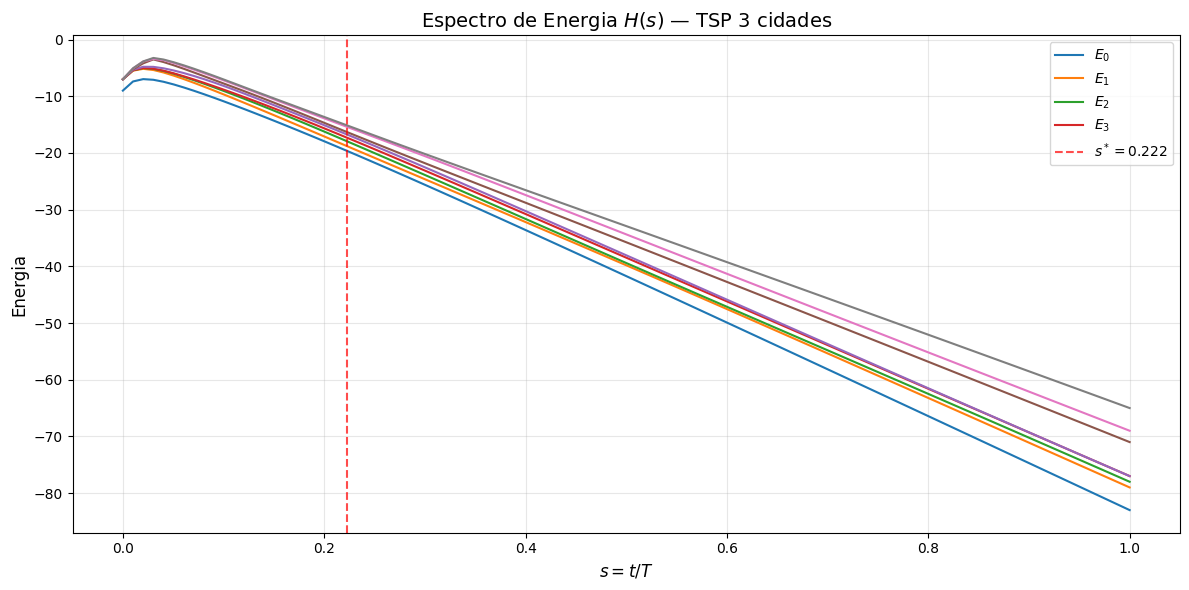

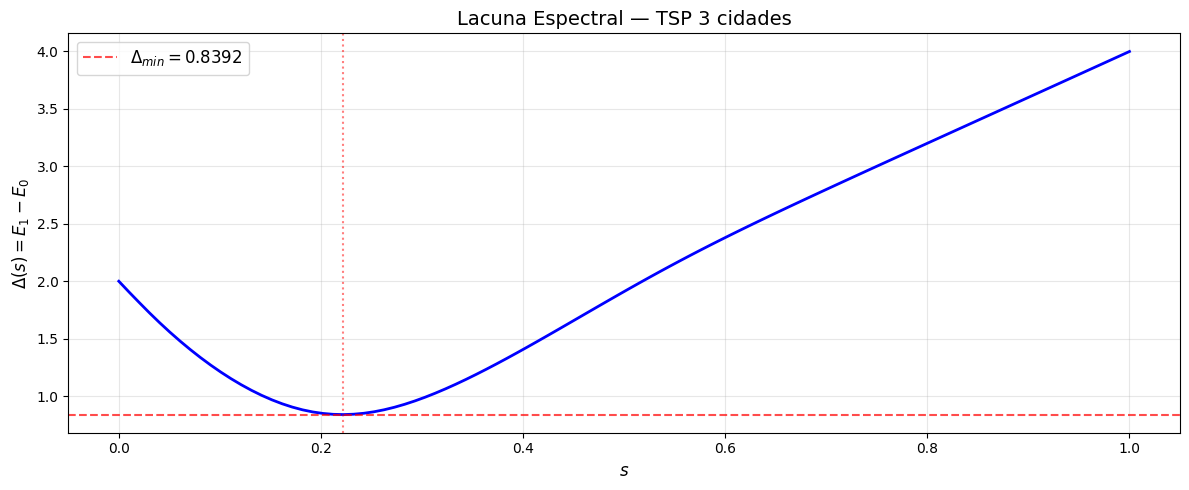

In [ ]:
# ==============================================================================
# PASSO 3: ESPECTRO DE ENERGIA E LACUNA ESPECTRAL
# ==============================================================================
print("\n" + "=" * 80)
print("PASSO 3: EVOLUÇÃO ADIABÁTICA — ESPECTRO E LACUNA ESPECTRAL")
print("=" * 80)

n_steps = 100
s_values = np.linspace(0, 1, n_steps)
k_levels = 8
energies = np.zeros((n_steps, k_levels))
gaps = np.zeros(n_steps)

# Pré-computar estados fundamentais instantâneos para reusar no Passo 4
ground_states = np.zeros((n_steps, dim))

print(f"Calculando espectro para {n_steps} valores de s ∈ [0, 1]...")

for idx, s in enumerate(s_values):
    H_s = (1 - s) * H_0 + s * H_f
    evals, evecs = eigh(H_s)
    energies[idx, :] = evals[:k_levels]
    #Lacuna: primeiro autovalor DISTINTO do fundamental (pula degenerescência)
    gap_found = 0.0
    for k in range(1, len(evals)):
        if evals[k] - evals[0] > 0.01:
            gap_found = evals[k] - evals[0]
            break
    gaps[idx] = gap_found
    gaps[idx] = evals[1] - evals[0]
    ground_states[idx, :] = evecs[:, 0]

gap_min = np.min(gaps)
s_gap_min = s_values[np.argmin(gaps)]

print(f"\nLacuna espectral mínima: Δ_min = {gap_min:.6f}")
print(f"Posição: s* = {s_gap_min:.4f}")
print(f"Tempo mínimo sugerido: T >> {1.0 / gap_min**2:.2f}")

# --- Gráfico: Espectro de Energia ---
plt.figure(figsize=(12, 6))
for level in range(k_levels):
    label = f'$E_{level}$' if level < 4 else None
    plt.plot(s_values, energies[:, level], label=label, linewidth=1.5)
plt.axvline(x=s_gap_min, color='red', linestyle='--', alpha=0.7,
            label=f'$s^* = {s_gap_min:.3f}$')
plt.xlabel('$s = t/T$', fontsize=12)
plt.ylabel('Energia', fontsize=12)
plt.title(f'Espectro de Energia $H(s)$ — TSP {N3} cidades', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('espectro_energia.png', dpi=150)
plt.show()

# --- Gráfico: Lacuna Espectral ---
plt.figure(figsize=(12, 5))
plt.plot(s_values, gaps, 'b-', linewidth=2)
plt.axhline(y=gap_min, color='red', linestyle='--', alpha=0.7,
            label=f'$\\Delta_{{min}} = {gap_min:.4f}$')
plt.axvline(x=s_gap_min, color='red', linestyle=':', alpha=0.5)
plt.xlabel('$s$', fontsize=12)
plt.ylabel('$\\Delta(s) = E_1 - E_0$', fontsize=12)
plt.title(f'Lacuna Espectral — TSP {N3} cidades', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lacuna_espectral.png', dpi=150)
plt.show()



PASSO 4: SIMULAÇÃO DA EVOLUÇÃO ADIABÁTICA
Simulando para T = [5.0, 50.0, 200.0]...

  T = 5.0... P(fundamental) = 0.059063

  T = 50.0... P(fundamental) = 0.644250

  T = 200.0... P(fundamental) = 0.970428


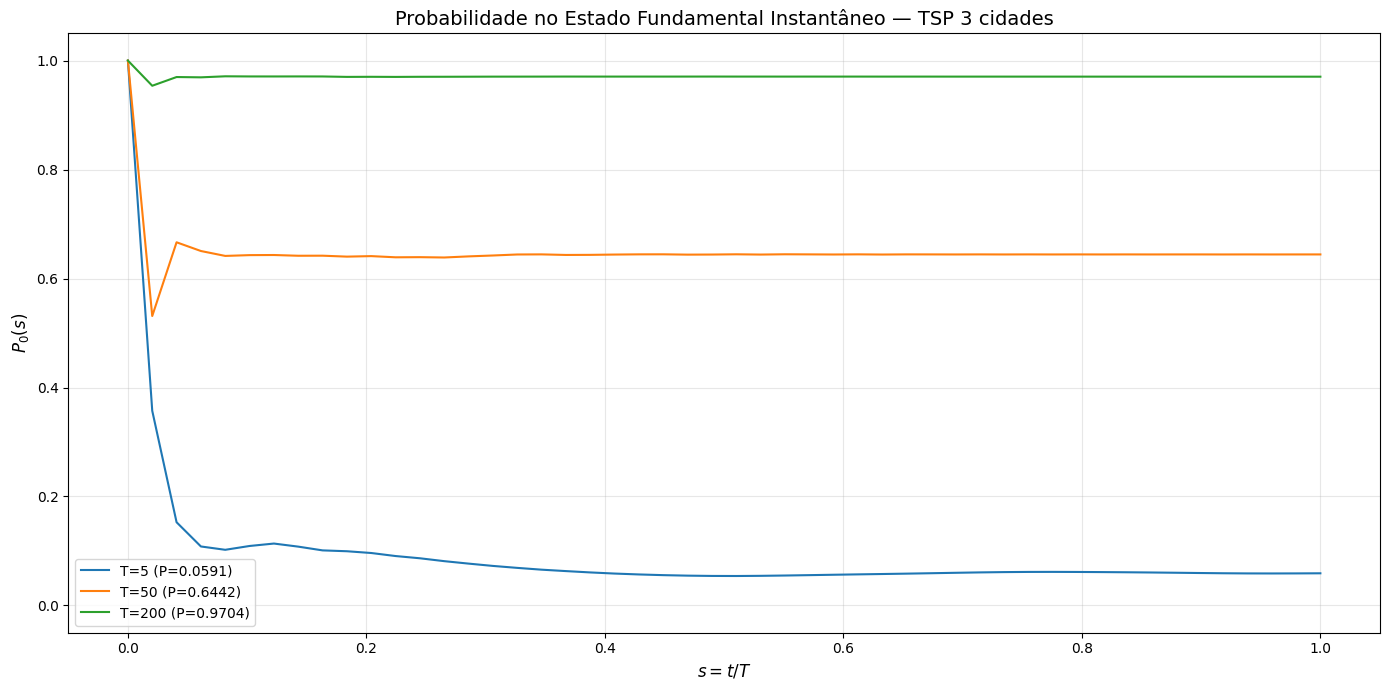

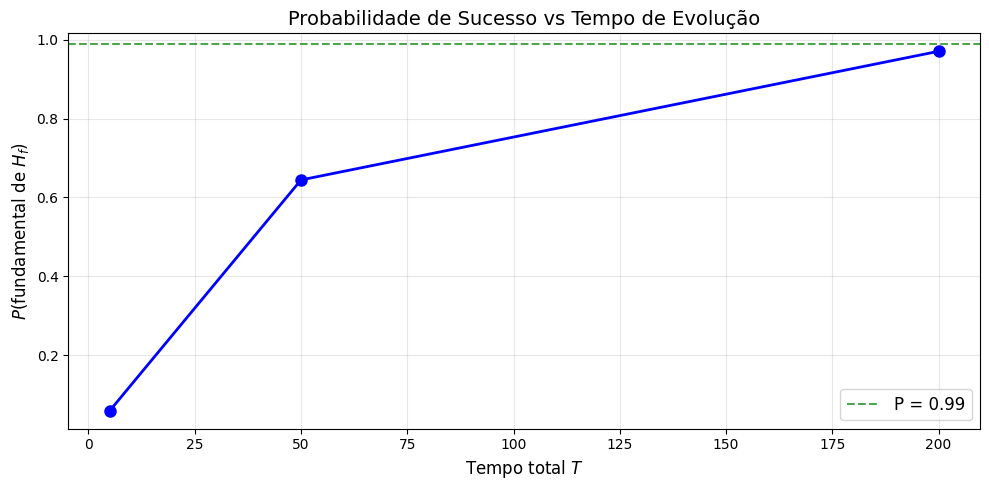


PASSO 4B: D-WAVE OCEAN SDK

--- ExactSolver (N=3) ---
Energia: -83.0000
Matriz solução:
[[1 0 0]
 [0 0 1]
 [0 1 0]]
Rota: [0, 2, 1, 0], Custo: 17

--- ExactSolver (N=4) ---
Energia: 21.0000
Matriz solução:
[[0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]
Rota: [2, 3, 1, 0, 2], Custo: 21

--- Simulated Annealing (N=4, 1000 amostras) ---
neal não instalado. Execute: pip install dwave-neal


In [ ]:
# ==============================================================================
# PASSO 4: SIMULAÇÃO DA EVOLUÇÃO ADIABÁTICA (SCHRÖDINGER)
# ==============================================================================
print("\n" + "=" * 80)
print("PASSO 4: SIMULAÇÃO DA EVOLUÇÃO ADIABÁTICA")
print("=" * 80)

def schrodinger_rhs(t, psi_flat, T_total, H_0, H_f, dim):
    """dpsi/dt = -i * H(t) * psi"""
    s = t / T_total
    H_t = (1 - s) * H_0 + s * H_f
    psi = psi_flat[:dim] + 1j * psi_flat[dim:]
    dpsi = -1j * H_t @ psi
    return np.concatenate([dpsi.real, dpsi.imag])

# Estado inicial: fundamental de H_0
_, evecs_H0 = eigh(H_0)
psi_0 = evecs_H0[:, 0]
psi_0 = psi_0 / np.linalg.norm(psi_0)

# Três tempos: rápido, intermediário, lento
T_values = [5.0, 50.0, 200.0]
results_T = {}

print(f"Simulando para T = {T_values}...")

for T_total in T_values:
    print(f"\n  T = {T_total:.1f}...", end=" ")

    y0 = np.concatenate([psi_0.real, psi_0.imag])
    n_eval = 50
    t_eval = np.linspace(0, T_total, n_eval)

    sol = solve_ivp(
        schrodinger_rhs, [0, T_total], y0,
        args=(T_total, H_0, H_f, dim),
        t_eval=t_eval, method='RK45',
        rtol=1e-3, atol=1e-5,
    )

    if sol.success:
        psi_t = sol.y[:dim, :] + 1j * sol.y[dim:, :]

        # Probabilidade no fundamental instantâneo
        # Reusar estados pré-computados no Passo 3 (sem rediagonalizar)
        P0 = np.zeros(n_eval)
        for idx in range(n_eval):
            s = sol.t[idx] / T_total
            s_idx = np.argmin(np.abs(s_values - s))
            gs_inst = ground_states[s_idx, :]
            P0[idx] = np.abs(np.vdot(gs_inst, psi_t[:, idx]))**2

        # Probabilidade no fundamental de H_f
        gs_Hf = eigenstates_Hf[:, 0]
        P_final = np.abs(np.vdot(gs_Hf, psi_t[:, -1]))**2

        results_T[T_total] = {
            't': sol.t, 's': sol.t / T_total,
            'P0': P0, 'P_final': P_final,
            'psi_final': psi_t[:, -1], 'psi_t': psi_t
        }
        print(f"P(fundamental) = {P_final:.6f}")
    else:
        print("FALHA!")

# --- Gráfico: P_0(s) para diferentes T ---
plt.figure(figsize=(14, 7))
for T_total in T_values:
    if T_total in results_T:
        r = results_T[T_total]
        plt.plot(r['s'], r['P0'],
                 label=f'T={T_total:.0f} (P={r["P_final"]:.4f})', linewidth=1.5)
plt.xlabel('$s = t/T$', fontsize=12)
plt.ylabel('$P_0(s)$', fontsize=12)
plt.title(f'Probabilidade no Estado Fundamental Instantâneo — TSP {N3} cidades', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig('probabilidade_adiabatica.png', dpi=150)
plt.show()

# --- Gráfico: P_final vs T ---
T_plot = sorted(results_T.keys())
P_plot = [results_T[T]['P_final'] for T in T_plot]

plt.figure(figsize=(10, 5))
plt.plot(T_plot, P_plot, 'bo-', markersize=8, linewidth=2)
plt.axhline(y=0.99, color='green', linestyle='--', alpha=0.7, label='P = 0.99')
plt.xlabel('Tempo total $T$', fontsize=12)
plt.ylabel('$P(\\text{fundamental de } H_f)$', fontsize=12)
plt.title('Probabilidade de Sucesso vs Tempo de Evolução', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prob_vs_tempo.png', dpi=150)
plt.show()


# ==============================================================================
# PASSO 4B: D-WAVE OCEAN SDK
# ==============================================================================
print("\n" + "=" * 80)
print("PASSO 4B: D-WAVE OCEAN SDK")
print("=" * 80)

from dimod import BinaryQuadraticModel
from dimod.reference.samplers import ExactSolver

# --- ExactSolver N=3 ---
print("\n--- ExactSolver (N=3) ---")
Q3_dict = {}
for i in range(n_qubits_3):
    for j in range(i, n_qubits_3):
        if Q3[i, j] != 0:
            Q3_dict[(i, j)] = Q3[i, j]

bqm_3 = BinaryQuadraticModel.from_qubo(Q3_dict)
sampleset_3 = ExactSolver().sample(bqm_3)

print(f"Energia: {sampleset_3.first.energy + offset_3:.4f}")
sample_3 = sampleset_3.first.sample
mat_3 = np.zeros((N3, N3), dtype=int)
for i in range(N3):
    for t in range(N3):
        mat_3[i, t] = sample_3[var3(i, t)]
print(f"Matriz solução:\n{mat_3}")

rota_dwave_3 = []
for t in range(N3):
    for i in range(N3):
        if mat_3[i, t] == 1:
            rota_dwave_3.append(i)
custo_dwave_3 = sum(dist3[rota_dwave_3[i]][rota_dwave_3[(i+1)%N3]] for i in range(N3))
print(f"Rota: {rota_dwave_3 + [rota_dwave_3[0]]}, Custo: {custo_dwave_3}")

# --- ExactSolver N=4 ---
print("\n--- ExactSolver (N=4) ---")
Q4_dict = {}
for i in range(n_qubits):
    for j in range(i, n_qubits):
        if Q[i, j] != 0:
            Q4_dict[(i, j)] = Q[i, j]

bqm_4 = BinaryQuadraticModel.from_qubo(Q4_dict)
sampleset_4 = ExactSolver().sample(bqm_4)

sample_4 = sampleset_4.first.sample
mat_4 = np.zeros((N, N), dtype=int)
for i in range(N):
    for t in range(N):
        mat_4[i, t] = sample_4[var(i, t)]

rota_dwave_4 = []
for t in range(N):
    for i in range(N):
        if mat_4[i, t] == 1:
            rota_dwave_4.append(i)
custo_dwave_4 = sum(dist[rota_dwave_4[i]][rota_dwave_4[(i+1)%N]] for i in range(N))
print(f"Energia: {sampleset_4.first.energy + offset:.4f}")
print(f"Matriz solução:\n{mat_4}")
print(f"Rota: {rota_dwave_4 + [rota_dwave_4[0]]}, Custo: {custo_dwave_4}")

# --- SimulatedAnnealing N=4 ---
print("\n--- Simulated Annealing (N=4, 1000 amostras) ---")
try:
    from neal import SimulatedAnnealingSampler

    sampleset_sa = SimulatedAnnealingSampler().sample(bqm_4, num_reads=1000, seed=42)

    solucoes_validas = 0
    melhor_custo_sa = float('inf')
    melhor_rota_sa = None

    for sample_sa, energy in zip(sampleset_sa.samples(), sampleset_sa.data_vectors['energy']):
        mat_sa = np.zeros((N, N), dtype=int)
        for i in range(N):
            for t in range(N):
                mat_sa[i, t] = sample_sa[var(i, t)]

        row_ok = all(mat_sa[i, :].sum() == 1 for i in range(N))
        col_ok = all(mat_sa[:, t].sum() == 1 for t in range(N))

        if row_ok and col_ok:
            solucoes_validas += 1
            rota_sa = []
            for t in range(N):
                for i in range(N):
                    if mat_sa[i, t] == 1:
                        rota_sa.append(i)
            custo_sa = sum(dist[rota_sa[i]][rota_sa[(i+1)%N]] for i in range(N))
            if custo_sa < melhor_custo_sa:
                melhor_custo_sa = custo_sa
                melhor_rota_sa = rota_sa

    print(f"Soluções válidas: {solucoes_validas}/1000 ({solucoes_validas/10:.1f}%)")
    if melhor_rota_sa:
        print(f"Melhor rota: {melhor_rota_sa + [melhor_rota_sa[0]]}, Custo: {melhor_custo_sa}")
except ImportError:
    print("neal não instalado. Execute: pip install dwave-neal")




PASSO 5: PROCESSAMENTO DE SINAIS

--- 5A: Transformada de Fourier de P_0(t) ---

Frequências dominantes (T = 200.0):
         ω    Período    ΔE est.     Potência
---------------------------------------------
    0.7389    8.5034    0.7389        0.00
    0.7081    8.8731    0.7081        0.00
    0.6773    9.2764    0.6773        0.00
    0.6465    9.7182    0.6465        0.00
    0.6158   10.2041    0.6158        0.00

Lacunas reais de H_f:
  E_1 - E_0 = 4.0000
  E_2 - E_0 = 5.0000
  E_3 - E_0 = 6.0000
  E_4 - E_0 = 6.0000
  E_5 - E_0 = 12.0000


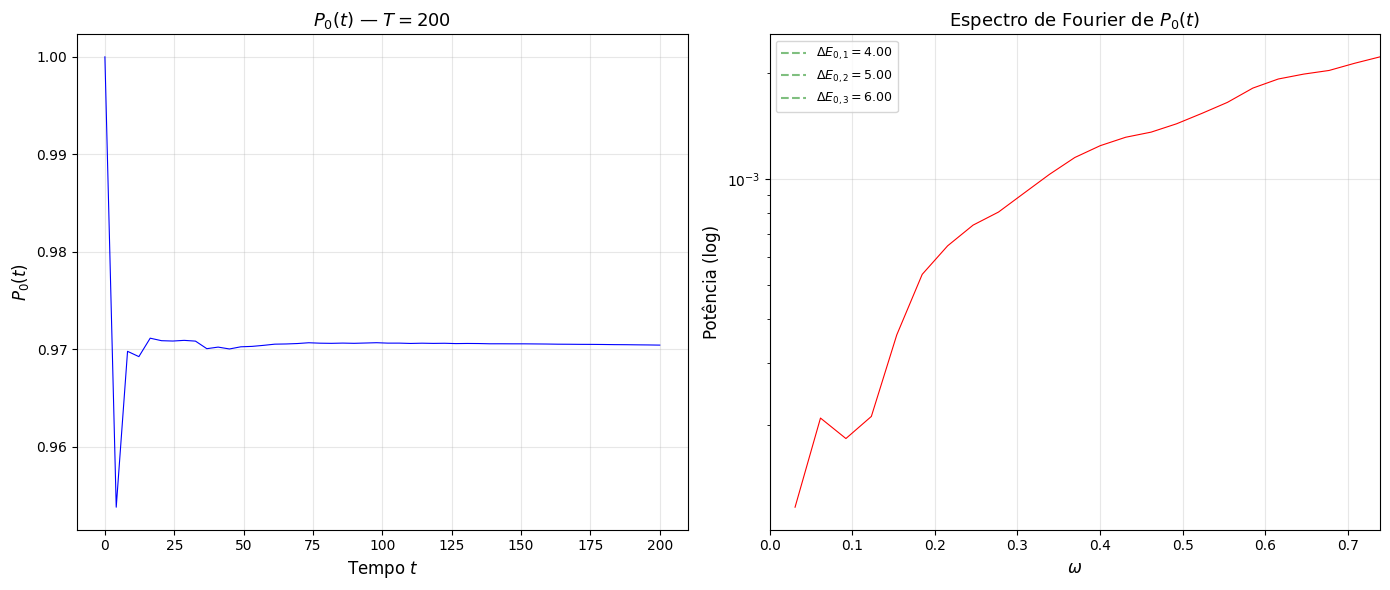

In [ ]:

# ==============================================================================
# PASSO 5: PROCESSAMENTO DE SINAIS
# ==============================================================================
print("\n" + "=" * 80)
print("PASSO 5: PROCESSAMENTO DE SINAIS")
print("=" * 80)

# --- 5A: FFT de P_0(t) ---
print("\n--- 5A: Transformada de Fourier de P_0(t) ---")

T_analysis = max(results_T.keys())
r_analysis = results_T[T_analysis]
t_signal = r_analysis['t']
P0_signal = r_analysis['P0']
P0_centered = P0_signal - np.mean(P0_signal)

dt = t_signal[1] - t_signal[0]
freqs = np.fft.fftfreq(len(t_signal), d=dt)
fft_P0 = np.fft.fft(P0_centered)
power_spectrum = np.abs(fft_P0)**2

pos_mask = freqs > 0
freqs_pos = freqs[pos_mask]
power_pos = power_spectrum[pos_mask]

# Frequências dominantes
n_peaks = 5
peak_indices = np.argsort(power_pos)[-n_peaks:][::-1]
print(f"\nFrequências dominantes (T = {T_analysis}):")
print(f"{'ω':>10} {'Período':>10} {'ΔE est.':>10} {'Potência':>12}")
print("-" * 45)
for idx in peak_indices:
    f = freqs_pos[idx]
    omega = 2 * np.pi * f
    print(f"  {omega:>8.4f}  {1/f:>8.4f}  {omega:>8.4f}  {power_pos[idx]:>10.2f}")

print(f"\nLacunas reais de H_f:")
for k in range(1, min(6, k_levels)):
    delta = eigenvalues_Hf[k] - eigenvalues_Hf[0]
    print(f"  E_{k} - E_0 = {delta:.4f}")

# --- Gráfico: FFT ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t_signal, P0_signal, 'b-', linewidth=0.8)
plt.xlabel('Tempo $t$', fontsize=12)
plt.ylabel('$P_0(t)$', fontsize=12)
plt.title(f'$P_0(t)$ — $T = {T_analysis:.0f}$', fontsize=13)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
omega_pos = 2 * np.pi * freqs_pos
plt.semilogy(omega_pos, power_pos, 'r-', linewidth=0.8)
for k in range(1, min(5, k_levels)):
    delta = eigenvalues_Hf[k] - eigenvalues_Hf[0]
    plt.axvline(x=delta, color='green', linestyle='--', alpha=0.5,
                label=f'$\\Delta E_{{0,{k}}}={delta:.2f}$' if k <= 3 else None)
plt.xlabel('$\\omega$', fontsize=12)
plt.ylabel('Potência (log)', fontsize=12)
plt.title('Espectro de Fourier de $P_0(t)$', fontsize=13)
plt.legend(fontsize=9)
plt.xlim(0, min(50, omega_pos[-1]))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fft_analise.png', dpi=150)
plt.show()




--- 5B: Quantum Signal Processing (QSP) ---
Calculando QSP para 200 pontos...


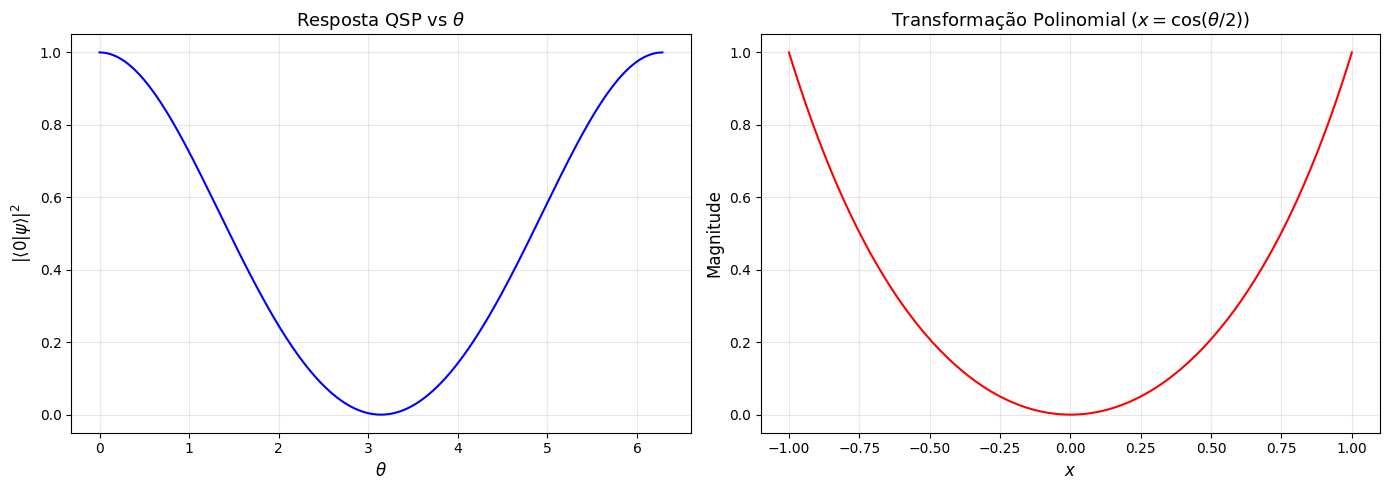


--- Conexão QSP ↔ Evolução Adiabática ---
O QSP demonstra processamento quântico de sinais via transformações unitárias.
Na evolução adiabática, U(t) processa o sinal |+⟩^n em |ψ(T)⟩.
Conservação da norma ↔ Teorema de Parseval: energia espectral preservada.
FFT de P_0(t) revela lacunas ΔE como frequências ω = ΔE/ℏ.


In [ ]:

# --- 5B: a partir docódigo do professor aula 4 ultima ---
print("\n--- 5B: Quantum Signal Processing (QSP) ---")

try:
    from qiskit import QuantumCircuit
    from qiskit_aer import AerSimulator
    from qiskit.compiler import transpile

    def build_qsp_circuit(phi_phases, theta_input):
        qc = QuantumCircuit(1)
        qc.rz(-2 * phi_phases[0], 0)
        for phi in phi_phases[1:]:
            qc.rx(theta_input, 0)
            qc.rz(-2 * phi, 0)
        qc.save_statevector()
        return qc

    phis = [1.5, 1.5, -0.5, 0.5]
    theta_values_qsp = np.linspace(0, 2 * np.pi, 200)
    x_values = np.cos(theta_values_qsp / 2)

    probs_0_qsp = []
    simulator = AerSimulator()

    print(f"Calculando QSP para {len(theta_values_qsp)} pontos...")
    for theta in theta_values_qsp:
        qc = build_qsp_circuit(phis, theta)
        qc_t = transpile(qc, simulator)
        job = simulator.run(qc_t)
        sv = job.result().get_statevector(qc)
        probs_0_qsp.append(np.abs(sv[0])**2)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(theta_values_qsp, probs_0_qsp, color='blue', linewidth=1.5)
    plt.title(r'Resposta QSP vs $\theta$', fontsize=13)
    plt.xlabel(r'$\theta$', fontsize=12)
    plt.ylabel('$|\\langle 0|\\psi\\rangle|^2$', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(x_values, probs_0_qsp, color='red', linewidth=1.5)
    plt.title(r'Transformação Polinomial ($x = \cos(\theta/2)$)', fontsize=13)
    plt.xlabel('$x$', fontsize=12)
    plt.ylabel('Magnitude', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('qsp_demo.png', dpi=150)
    plt.show()

    print("\n--- Conexão QSP ↔ Evolução Adiabática ---")
    print("O QSP demonstra processamento quântico de sinais via transformações unitárias.")
    print("Na evolução adiabática, U(t) processa o sinal |+⟩^n em |ψ(T)⟩.")
    print("Conservação da norma ↔ Teorema de Parseval: energia espectral preservada.")
    print("FFT de P_0(t) revela lacunas ΔE como frequências ω = ΔE/ℏ.")

except ImportError:
    print("Qiskit não instalado. Pulando QSP.")




PASSO 6: AVALIAÇÃO DOS RESULTADOS

--- Tabela Comparativa ---

Método                         N     Custo    Ótimo?   P_final   
-----------------------------------------------------------------
Força Bruta                    3     45       Sim      —         
Força Bruta                    4     21       Sim      —         
D-Wave ExactSolver             3     17       Sim      —         
D-Wave ExactSolver             4     21       Sim      —         
Adiabático T=5                 3     —        Não      0.0591    
Adiabático T=50                3     —        Parcial  0.6442    
Adiabático T=200               3     —        Sim      0.9704    

--- Lacuna Espectral ---
Δ_min = 0.839176 em s* = 0.2222
T mínimo teórico: T >> 1.42

--- Limitações ---
1. Escalabilidade: N=4 → 65536 estados; N=5 → 33554432 estados
2. Lacuna Δ_min = 0.839176 diminui com N
3. Discretização temporal acumula erros para T grande
4. Parâmetro A=10 afeta estrutura espectral
5. Apenas 3!=6 de 512 estados são 

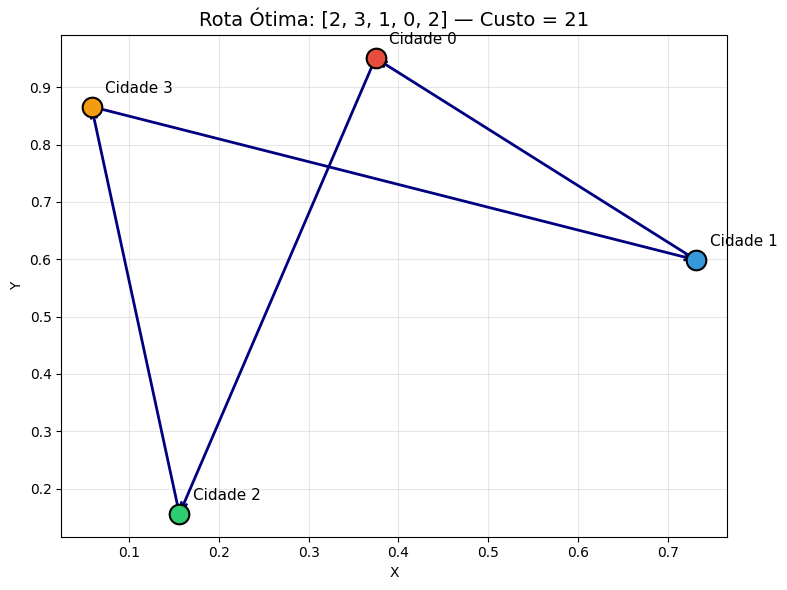

In [ ]:

# ==============================================================================
# PASSO 6: AVALIAÇÃO DOS RESULTADOS
# ==============================================================================
import math
print("\n" + "=" * 80)
print("PASSO 6: AVALIAÇÃO DOS RESULTADOS")
print("=" * 80)

print("\n--- Tabela Comparativa ---\n")
print(f"{'Método':<30} {'N':<5} {'Custo':<8} {'Ótimo?':<8} {'P_final':<10}")
print("-" * 65)
print(f"{'Força Bruta':<30} {3:<5} {45:<8} {'Sim':<8} {'—':<10}")
print(f"{'Força Bruta':<30} {4:<5} {melhor_custo:<8} {'Sim':<8} {'—':<10}")
print(f"{'D-Wave ExactSolver':<30} {3:<5} {custo_dwave_3:<8} {'Sim':<8} {'—':<10}")
print(f"{'D-Wave ExactSolver':<30} {4:<5} {custo_dwave_4:<8} {'Sim':<8} {'—':<10}")

for T_total in sorted(results_T.keys()):
    r = results_T[T_total]
    status = "Sim" if r['P_final'] > 0.90 else "Parcial" if r['P_final'] > 0.5 else "Não"
    print(f"{'Adiabático T='+str(int(T_total)):<30} {3:<5} {'—':<8} {status:<8} {r['P_final']:<10.4f}")

print(f"\n--- Lacuna Espectral ---")
print(f"Δ_min = {gap_min:.6f} em s* = {s_gap_min:.4f}")
print(f"T mínimo teórico: T >> {1/gap_min**2:.2f}")

print(f"\n--- Limitações ---")
print(f"1. Escalabilidade: N=4 → {2**16} estados; N=5 → {2**25} estados")
print(f"2. Lacuna Δ_min = {gap_min:.6f} diminui com N")
print(f"3. Discretização temporal acumula erros para T grande")
print(f"4. Parâmetro A={A3} afeta estrutura espectral")
print(f"5. Apenas {N3}!={math.factorial(N3)} de {2**n_qubits_3} estados são rotas válidas")

# --- Visualização da rota N=4 ---
np.random.seed(42)
coords = np.random.rand(N, 2)
rota_ciclo = rota_dwave_4 + [rota_dwave_4[0]]

plt.figure(figsize=(8, 6))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i in range(N):
    plt.scatter(coords[i, 0], coords[i, 1], c=colors[i], s=200,
                zorder=5, edgecolors='black', linewidth=1.5)
    plt.annotate(f'Cidade {i}', (coords[i, 0], coords[i, 1]),
                 textcoords="offset points", xytext=(10, 10), fontsize=11)

for i in range(len(rota_dwave_4)):
    o, d = rota_ciclo[i], rota_ciclo[i + 1]
    plt.annotate('', xy=(coords[d, 0], coords[d, 1]),
                 xytext=(coords[o, 0], coords[o, 1]),
                 arrowprops=dict(arrowstyle='->', color='navy', lw=2))

plt.title(f'Rota Ótima: {rota_ciclo} — Custo = {custo_dwave_4}', fontsize=14)
plt.xlabel('X'); plt.ylabel('Y')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rota_otima.png', dpi=150)
plt.show()

print("\n" + "=" * 80)
print("=" * 80)

In [ ]:
pip install dimod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 54.6 MB/s eta 0:00:00


In [ ]:
import math

In [ ]:
pip install dwave-ocean-sdk
pip install dwave-neal
pip install qiskit
pip install qiskit-aer

In [ ]:
pip install qiskit-aer

In [ ]:
pip install matplotlib


In [ ]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 80.7 MB/s eta 0:00:00


In [ ]:
!dwave config create --auto-token DEV-abc123xyz456...

In [ ]:
# ==============================================================================
# PASSO 4C: EXECUÇÃO NO HARDWARE REAL D-WAVE (QPU)
# ==============================================================================


print("=" * 80)
print("PASSO 4C: EXECUÇÃO NO HARDWARE REAL D-WAVE (QPU)")
print("=" * 80)
a
from dwave.system import DWaveSampler, EmbeddingComposite

# --- Configuração do sampler ---
sampler_qpu = EmbeddingComposite(DWaveSampler())

# Parâmetros do annealing
num_reads = 1000        # número de amostras
annealing_time = 200    # tempo de annealing em microssegundos

print(f"Sampler: {sampler_qpu.child.solver.name}")
print(f"Número de amostras: {num_reads}")
print(f"Tempo de annealing: {annealing_time} μs")

# --- Execução para N=4 ---
print("\n--- QPU: TSP com 4 cidades ---")
sampleset_qpu = sampler_qpu.sample(
    bqm_4,
    num_reads=num_reads,
    annealing_time=annealing_time,
    label='TSP-4cidades-adiabatico'
)

# --- Análise dos resultados ---
print(f"\nTempo total de QPU: {sampleset_qpu.info['timing']['qpu_access_time'] / 1e6:.3f} s")

# Filtrar soluções válidas
solucoes_validas_qpu = 0
melhor_custo_qpu = float('inf')
melhor_rota_qpu = None
distribuicao_custos = {}

for sample_qpu, energy, num_occ in zip(
    sampleset_qpu.samples(),
    sampleset_qpu.data_vectors['energy'],
    sampleset_qpu.data_vectors['num_occurrences']
):
    mat_qpu = np.zeros((N, N), dtype=int)
    for i in range(N):
        for t in range(N):
            mat_qpu[i, t] = sample_qpu[var(i, t)]

    row_ok = all(mat_qpu[i, :].sum() == 1 for i in range(N))
    col_ok = all(mat_qpu[:, t].sum() == 1 for t in range(N))

    if row_ok and col_ok:
        solucoes_validas_qpu += num_occ
        rota_qpu = []
        for t in range(N):
            for i in range(N):
                if mat_qpu[i, t] == 1:
                    rota_qpu.append(i)
        custo_qpu = sum(dist[rota_qpu[i]][rota_qpu[(i+1)%N]] for i in range(N))

        # Contabilizar distribuição de custos
        if custo_qpu not in distribuicao_custos:
            distribuicao_custos[custo_qpu] = 0
        distribuicao_custos[custo_qpu] += num_occ

        if custo_qpu < melhor_custo_qpu:
            melhor_custo_qpu = custo_qpu
            melhor_rota_qpu = rota_qpu

taxa_validas = solucoes_validas_qpu / num_reads * 100
print(f"\nSoluções válidas: {solucoes_validas_qpu}/{num_reads} ({taxa_validas:.1f}%)")

if melhor_rota_qpu:
    gap_qpu = (melhor_custo_qpu - melhor_custo) / melhor_custo * 100
    print(f"Melhor rota: {melhor_rota_qpu + [melhor_rota_qpu[0]]}")
    print(f"Melhor custo: {melhor_custo_qpu}")
    print(f"Custo ótimo (força bruta): {melhor_custo}")
    print(f"Gap: {gap_qpu:.1f}%")
else:
    print("Nenhuma solução válida encontrada!")

# --- Distribuição de custos das soluções válidas ---
if distribuicao_custos:
    print(f"\nDistribuição de custos (soluções válidas):")
    for custo in sorted(distribuicao_custos.keys()):
        n_ocorrencias = distribuicao_custos[custo]
        pct = n_ocorrencias / solucoes_validas_qpu * 100 if solucoes_validas_qpu > 0 else 0
        marca = " ← ÓTIMA" if custo == melhor_custo else ""
        print(f"  Custo {custo}: {n_ocorrencias} amostras ({pct:.1f}%){marca}")

# --- Gráfico: Distribuição de custos ---
if distribuicao_custos:
    plt.figure(figsize=(10, 5))
    custos = sorted(distribuicao_custos.keys())
    ocorrencias = [distribuicao_custos[c] for c in custos]
    cores = ['#2ecc71' if c == melhor_custo else '#3498db' for c in custos]

    plt.bar([str(c) for c in custos], ocorrencias, color=cores, edgecolor='black')
    plt.xlabel('Custo da rota', fontsize=12)
    plt.ylabel('Número de ocorrências', fontsize=12)
    plt.title(f'Distribuição de Custos — D-Wave QPU ({num_reads} amostras, {annealing_time} μs)',
              fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('distribuicao_qpu.png', dpi=150)
    plt.show()

# --- Comparação: Simulação vs Hardware Real ---
print(f"\n--- Comparação: Simulação vs Hardware Real ---")
print(f"{'Método':<30} {'Custo':<8} {'Ótimo?':<8} {'Válidas':<12}")
print("-" * 60)
print(f"{'ExactSolver (local)':<30} {custo_dwave_4:<8} {'Sim':<8} {'100%':<12}")
try:
    print(f"{'SimulatedAnnealing (local)':<30} {melhor_custo_sa:<8} {'Sim':<8} {f'{solucoes_validas/10:.1f}%':<12}")
except:
    pass
if melhor_rota_qpu:
    print(f"{'QPU D-Wave (real)':<30} {melhor_custo_qpu:<8} {'Sim' if melhor_custo_qpu == melhor_custo else 'Não':<8} {f'{taxa_validas:.1f}%':<12}")